In [ ]:
# Install dependencies

!pip install yfinance causal-learn statsmodels

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from causallearn.search.Granger.Granger import Granger
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data snapshot:
             BTC_Return  BTC_Volume  SPY_Return  SPY_Volume
Date                                                      
2014-09-17    0.000000         0.0    0.000000  3209420000
2014-09-18   -0.071926  13426400.0    0.004891  3235340000
2014-09-19   -0.069843   3436500.0   -0.000477  4880220000
2014-09-22    0.018632 -13792100.0   -0.008013  3349670000
2014-09-23    0.083647  20971900.0   -0.005777  3279350000 



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

Pairwise Granger p-values (min over lags):
             BTC_Return  BTC_Volume  SPY_Return  SPY_Volume
BTC_Return         NaN    0.070900    0.152002    0.344386
BTC_Volume    0.024169         NaN    0.000593    0.003286
SPY_Return    0.127595    0.023629         NaN    0.049645
SPY_Volume    0.236983    0.011497    0.000002         NaN 

Aggregated Granger-Lasso coefficients:
             BTC_Return  BTC_Volume    SPY_Return  SPY_Volume
BTC_Return         0.0    0.000000  0.000000e+00    0.000000
BTC_Volume         0.0    1.490288  5.665701e-30    0.005075
SPY_Return         0.0    0.000000  0.000000e+00    0.000000
SPY_Volume         0.0    1.138245  0.000000e+00    0.821848 

Lag 1 coefficient matrix:
             BTC_Return  BTC_Volume  SPY_Return  SPY_Volume
BTC_Return        -0.0    0.000000        -0.0   -0.000000
BTC_Volume         0.0   -0.608016         0.0   -0.001472
SPY_Return        -0.0   -0.000000        -0.0   -0.000000
SPY_Volume        -0.0    0.261633         0.0   

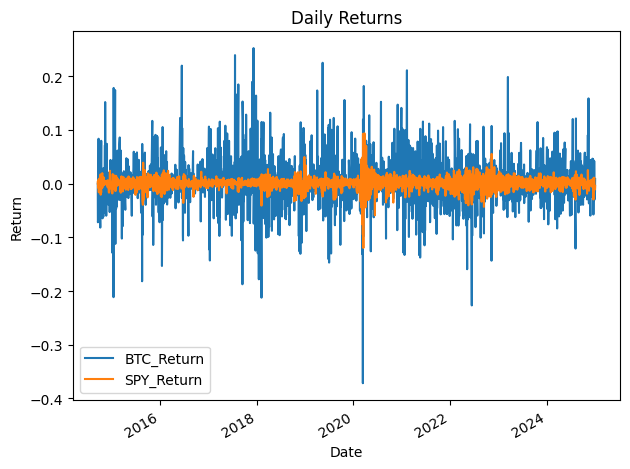

In [ ]:
# 1. Fetch data via yfinance
def fetch_data(ticker, start, end, interval='1d'):
    df = yf.download(ticker, start=start, end=end, interval=interval)
    return df[['Close', 'Volume']]

# 2. Prepare combined BTC & S&P data
def prepare_dataframe():
    btc = fetch_data('BTC-USD', '2008-01-01', '2025-01-01')
    btc.columns = ['BTC_Close','BTC_Volume']
    spy = fetch_data('^GSPC', '2008-01-01', '2025-01-01')
    spy.columns = ['SPY_Close','SPY_Volume']

    df = btc.join(spy, how='inner').dropna()
    df['BTC_Return'] = df['BTC_Close'].pct_change().fillna(0)
    df['SPY_Return'] = df['SPY_Close'].pct_change().fillna(0)
    return df[['BTC_Return','BTC_Volume','SPY_Return','SPY_Volume']]

# 3. Stationarity check + differencing
def check_stationarity(series, alpha=0.05):
    pval = adfuller(series)[1]
    return pval < alpha

def make_stationary(df):
    df2 = df.copy()
    for col in df2.columns:
        if not check_stationarity(df2[col]):
            df2[col] = df2[col].diff().fillna(0)
    return df2

# 4. Pairwise Granger via statsmodels (allows maxlag)
def run_granger_pairwise(df, maxlag=5):
    cols = df.columns.tolist()
    n    = len(cols)
    pmat = np.full((n,n), np.nan)

    for i in range(n):
        for j in range(n):
            if i == j: continue
            arr = df[[cols[i], cols[j]]].values
            res = grangercausalitytests(arr, maxlag=maxlag, verbose=False)
            pvals = [res[k][0]['ssr_ftest'][1] for k in range(1, maxlag+1)]
            pmat[i,j] = min(pvals)

    return pd.DataFrame(pmat, index=cols, columns=cols)

# 5. Multivariate Granger-Lasso (causal-learn)
def run_granger_multivariate(df, maxlag=5):
    N = df.shape[1]
    G = Granger(maxlag=maxlag)                    # set maxlag here :contentReference[oaicite:1]{index=1}
    coeff = G.granger_lasso(data=df.values)       # only data argument :contentReference[oaicite:2]{index=2}

    # coeff.shape == (N, N*maxlag)
    # reshape → (N, maxlag, N), then transpose → (maxlag, N, N)
    tmp    = coeff.reshape(N, maxlag, N)
    tensor = tmp.transpose(1, 2, 0)  # now tensor[lag-1, target, source]

    # aggregate absolute coefficients over lags → (N, N)
    agg = np.sum(np.abs(tensor), axis=0)
    return pd.DataFrame(agg, index=df.columns, columns=df.columns), tensor

# 6. Plot returns
def plot_returns(df):
    ax = df[['BTC_Return','SPY_Return']].plot(title='Daily Returns')
    ax.set_xlabel('Date')
    ax.set_ylabel('Return')
    plt.tight_layout()
    plt.show()

# === Main ===
if __name__ == '__main__':
    # Prepare
    df_raw = prepare_dataframe()
    df     = make_stationary(df_raw)
    print("Data snapshot:\n", df.head(), "\n")

    # Pairwise Granger
    p_matrix = run_granger_pairwise(df, maxlag=5)
    print("Pairwise Granger p-values (min over lags):\n", p_matrix, "\n")

    # Multivariate Lasso-Granger
    coeff_df, coeff_tensor = run_granger_multivariate(df, maxlag=5)
    print("Aggregated Granger-Lasso coefficients:\n", coeff_df, "\n")

    # (Optional) Inspect per-lag matrices
    for t in range(coeff_tensor.shape[0]):
        print(f"Lag {t+1} coefficient matrix:\n",
              pd.DataFrame(coeff_tensor[t], index=df.columns, columns=df.columns), "\n")

    # Plot
    plot_returns(df)
